# NLP Assignment 2: Language Model

**Student Name**: HTUT KO KO
**ID**: st126010

I have designed this notebook to run on **Google Colab** or **Local Machines (Mac M1/M2/M4 or Intel based CPU and CUDNN)**.


In [10]:
# --- OS runtime SETUP & CONFIGURATION ---
import os
import torch
import sys

# 1. Environment Detection
try:
    from google.colab import drive
    IS_COLAB = True
except ImportError:
    IS_COLAB = False

# 2. Setup based on Environment
if IS_COLAB:
    print("Detected Google Colab.")

    # Mount Drive
    drive.mount('/content/drive')

    # --- CONFIG: UPDATE THIS PATH TO YOUR SHARED DRIVE LOCATION ---
    PROJECT_PATH = '/content/drive/MyDrive/NLP/project_A2'
    # -------------------------------------------------------------

    if not os.path.exists(PROJECT_PATH):
        print(f"Warning: Path {PROJECT_PATH} not found. Creating it...")
        os.makedirs(PROJECT_PATH, exist_ok=True)

    os.chdir(PROJECT_PATH)
    print(f"Working Directory set to: {os.getcwd()}")

    # Install Deps
    print("Installing dependencies...")
    %pip install datasets tqdm matplotlib

else:
    print("Detected Local Environment.")
    # Smart Local Path Logic
    # If running from root (parent of project), perform check
    if os.path.exists('project_A2') and os.path.isdir('project_A2'):
        PROJECT_PATH = 'project_A2'
    else:
        # Assume we are already inside the project folder
        PROJECT_PATH = '.'

    print(f"Project Path target: {PROJECT_PATH}")

# 3. Hardware / Model Settings
# Change these based on the machine!

# OPTION A: High Performance (Mac M4 / Colab T4/V100)
EMB_DIM = 1024
HID_DIM = 1024
BATCH_SIZE = 64

# OPTION B: Standard Stable (Mac M1/M2 16GB) <-- DEFAULT
# EMB_DIM = 512
# HID_DIM = 512
# BATCH_SIZE = 32

# OPTION C: Ultra Safe (Older Macs / Low RAM)
# EMB_DIM = 256
# HID_DIM = 256
# BATCH_SIZE = 16

SEQ_LEN = 50

print(f"Config: Emb={EMB_DIM}, Hid={HID_DIM}, Batch={BATCH_SIZE}, Seq={SEQ_LEN}")

# Device Config
device = torch.device('cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu')
print(f'Using device: {device}')


Detected Google Colab.
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Working Directory set to: /content/drive/MyDrive/NLP/project_A2
Installing dependencies...
Config: Emb=1024, Hid=1024, Batch=64, Seq=50
Using device: cuda


In [11]:
import torch.nn as nn
import torch.optim as optim
import datasets
import math
import re
import requests
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from tqdm import tqdm

# Reproducibility
SEED = 1234
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

## Task 1. Dataset Acquisition
**Objective**: Find a suitable text dataset.

We have chosen **"The Adventures of Sherlock Holmes"** by Arthur Conan Doyle from Project Gutenberg.
The code below automatically downloads it to the correct project folder.


In [12]:
# Download the dataset
url = "https://www.gutenberg.org/files/1661/1661-0.txt"
filename = "Sherlock_Holmes.txt"

def download_file(url, filename, base_path):
    # Construct full path based on the Smart Setup
    save_path = os.path.join(base_path, filename)

    # Local check (if base_path is '.' it might be cleaner to just use filename)
    if base_path == '.':
        save_path = filename

    if os.path.exists(save_path):
        print(f"{save_path} already exists. Skipping download.")
        return save_path

    print(f"Downloading to {save_path}...")
    try:
        response = requests.get(url)
        response.raise_for_status()
        response.encoding = 'utf-8'
        with open(save_path, 'w', encoding='utf-8') as f:
            f.write(response.text)
        print("Download complete.")
        return save_path
    except Exception as e:
        print(f"Failed to download: {e}")
        return None

# Use PROJECT_PATH determined in the first cell
data_file_path = download_file(url, filename, PROJECT_PATH)

/content/drive/MyDrive/NLP/project_A2/Sherlock_Holmes.txt already exists. Skipping download.


## Task 2. Model Training

### 1) Preprocessing the Text Data
We perform the following preprocessing steps:
1.  **Header/Footer Removal**: Remove the Project Gutenberg license headers.
2.  **Cleaning**: Lowercase, separate punctuation.


In [13]:
# --- Preprocessing Functions ---

def remove_gutenberg_headers(text):
    """Removes the Project Gutenberg header and footer content."""
    start_match = re.search(r'\*\*\* START OF THE PROJECT GUTENBERG EBOOK [\s\S]*? \*\*\*', text, re.IGNORECASE)
    end_match = re.search(r'\*\*\* END OF THE PROJECT GUTENBERG EBOOK [\s\S]*? \*\*\*', text, re.IGNORECASE)
    start_idx = start_match.end() if start_match else 0
    end_idx = end_match.start() if end_match else len(text)
    return text[start_idx:end_idx].strip()

def basic_english_tokenizer(text):
    """Simple tokenizer: Lowercase, space punctuation, split."""
    text = text.lower()
    text = re.sub(r'([.,!?()])', r' \1 ', text)
    text = re.sub(r'[^a-z0-9\s.,!?()]', '', text)
    return text.split()

# Load and Process
print(f"Loading data from: {data_file_path}")
with open(data_file_path, 'r', encoding='utf-8') as f:
    raw_text = f.read()

clean_text = remove_gutenberg_headers(raw_text)
print(f"Raw length: {len(raw_text)}")
print(f"Cleaned length: {len(clean_text)}")

# Save intermediate cleaned file relative to the data file
cleaned_filename = 'Sherlock_Holmes_Cleaned.txt'
save_dir = os.path.dirname(data_file_path)
save_path = os.path.join(save_dir, cleaned_filename) if save_dir else cleaned_filename

with open(save_path, 'w', encoding='utf-8') as f:
    f.write(clean_text)

# Create Dataset Object
dataset = datasets.load_dataset('text', data_files={'train': save_path})
print(dataset)

Loading data from: /content/drive/MyDrive/NLP/project_A2/Sherlock_Holmes.txt
Raw length: 581425
Cleaned length: 562202


Generating train split: 0 examples [00:00, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['text'],
        num_rows: 11922
    })
})


### Tokenization and Vocabulary Building

Map:   0%|          | 0/11922 [00:00<?, ? examples/s]

Vocabulary Size: 3112


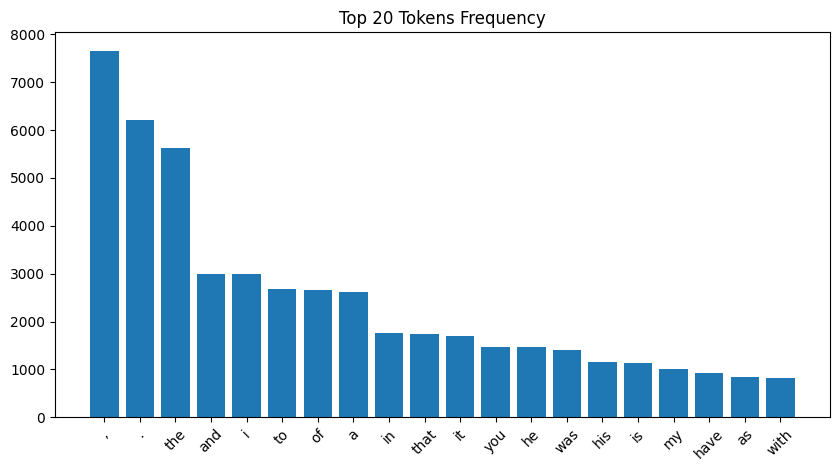

Saved vocab.pt to /content/drive/MyDrive/NLP/project_A2/app/vocab.pt


In [14]:
class SimpleVocab:
    def __init__(self, token_counts, min_freq=1, specials=['<unk>', '<pad>', '<eos>']):
        self.stoi = {}
        self.itos = []
        self.specials = specials
        for s in specials:
            self.stoi[s] = len(self.itos)
            self.itos.append(s)
        sorted_tokens = sorted(token_counts.items(), key=lambda x: x[1], reverse=True)
        for token, count in sorted_tokens:
            if count >= min_freq:
                if token not in self.stoi:
                    self.stoi[token] = len(self.itos)
                    self.itos.append(token)
        self.unk_index = self.stoi.get('<unk>', 0)
        self.pad_index = self.stoi.get('<pad>', 1)
        self.eos_index = self.stoi.get('<eos>', 2)
    def __len__(self): return len(self.itos)
    def __getitem__(self, token): return self.stoi.get(token, self.unk_index)

# Tokenize
tokenize_data = lambda example: {'tokens': basic_english_tokenizer(example['text'])}
tokenized_dataset = dataset.map(tokenize_data, remove_columns=['text'])

# Build Vocab
token_counts = Counter()
for tokens in tokenized_dataset['train']['tokens']:
    token_counts.update(tokens)

vocab = SimpleVocab(token_counts, min_freq=3)
print(f"Vocabulary Size: {len(vocab)}")

# Visualize
most_common = token_counts.most_common(20)
tokens, counts = zip(*most_common)
plt.figure(figsize=(10, 5))
plt.bar(tokens, counts)
plt.title('Top 20 Tokens Frequency')
plt.xticks(rotation=45)
plt.show()

# Save Vocab (to 'app' folder inside project path)
def save_artifact(obj, filename):
    # Determine app path based on PROJECT_PATH
    app_dir = os.path.join(PROJECT_PATH, 'app')
    if not os.path.exists(app_dir):
        # Maybe PROJECT_PATH is just '.' and we are in root?
        # Let's try to find or create 'app'
        if os.path.exists('app'):
             app_dir = 'app'
        elif os.path.exists(os.path.join('project', 'app')):
             app_dir = os.path.join('project', 'app')
        else:
             os.makedirs(app_dir, exist_ok=True)

    path = os.path.join(app_dir, filename)
    torch.save(obj, path)
    print(f"Saved {filename} to {path}")

save_artifact(vocab, 'vocab.pt')

### Batching (PyTorch DataLoader)

In [15]:
from torch.utils.data import Dataset, DataLoader

class LMDataset(Dataset):
    def __init__(self, data, vocab, seq_len):
        self.vocab = vocab
        self.seq_len = seq_len
        self.tokens = []
        unk_index = vocab.unk_index
        for example in data:
            if example['tokens']:
                ts = example['tokens'] + ['<eos>']
                self.tokens.extend([vocab.stoi.get(t, unk_index) for t in ts])
        self.tokens = torch.LongTensor(self.tokens)
        self.num_samples = (len(self.tokens) - 1) // seq_len

    def __len__(self): return self.num_samples
    def __getitem__(self, idx):
        start = idx * self.seq_len
        end = start + self.seq_len
        return self.tokens[start:end], self.tokens[start+1:end+1]

# USING CONFIG FROM TOP CELL
lm_dataset = LMDataset(tokenized_dataset['train'], vocab, SEQ_LEN)
train_size = int(0.9 * len(lm_dataset))
valid_size = len(lm_dataset) - train_size
train_dataset, valid_dataset = torch.utils.data.random_split(lm_dataset, [train_size, valid_size])

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
valid_loader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=False, drop_last=True)
print(f"Train Batches: {len(train_loader)}")

Train Batches: 36


### 2) Model Architecture

In [16]:
class LSTMLanguageModel(nn.Module):
    def __init__(self, vocab_size, emb_dim, hid_dim, num_layers, dropout_rate):
        super().__init__()
        self.num_layers = num_layers
        self.hid_dim = hid_dim
        self.emb_dim = emb_dim

        self.embedding = nn.Embedding(vocab_size, emb_dim)
        self.lstm = nn.LSTM(emb_dim, hid_dim, num_layers=num_layers, dropout=dropout_rate, batch_first=True)
        self.dropout = nn.Dropout(dropout_rate)
        self.fc = nn.Linear(hid_dim, vocab_size)
        self.init_weights()

    def init_weights(self):
        init_range = 0.1
        self.embedding.weight.data.uniform_(-init_range, init_range)
        self.fc.weight.data.uniform_(-init_range, init_range)
        self.fc.bias.data.zero_()

    def init_hidden(self, batch_size, device):
        return (torch.zeros(self.num_layers, batch_size, self.hid_dim).to(device),
                torch.zeros(self.num_layers, batch_size, self.hid_dim).to(device))

    def detach_hidden(self, hidden):
        return (hidden[0].detach(), hidden[1].detach())

    def forward(self, src, hidden):
        embedded = self.dropout(self.embedding(src))
        output, hidden = self.lstm(embedded, hidden)
        output = self.dropout(output)
        prediction = self.fc(output)
        return prediction, hidden

# USING CONFIG FROM TOP CELL
vocab_size = len(vocab)
num_layers = 2
dropout_rate = 0.6 if EMB_DIM > 512 else 0.5
lr = 1e-3

model = LSTMLanguageModel(vocab_size, EMB_DIM, HID_DIM, num_layers, dropout_rate).to(device)
optimizer = optim.Adam(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

print(f'Trainable parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}')

Trainable parameters: 23,170,088


### Training Process

Epoch: 1 | Train PPL: 537.530 | Valid PPL: 229.066
Saved model.pt to /content/drive/MyDrive/NLP/project_A2/app/model.pt


Epoch: 2 | Train PPL: 198.235 | Valid PPL: 153.450
Saved model.pt to /content/drive/MyDrive/NLP/project_A2/app/model.pt


Epoch: 3 | Train PPL: 141.435 | Valid PPL: 118.896
Saved model.pt to /content/drive/MyDrive/NLP/project_A2/app/model.pt


Epoch: 4 | Train PPL: 111.793 | Valid PPL: 101.307
Saved model.pt to /content/drive/MyDrive/NLP/project_A2/app/model.pt


Epoch: 5 | Train PPL: 95.959 | Valid PPL: 93.164
Saved model.pt to /content/drive/MyDrive/NLP/project_A2/app/model.pt


Epoch: 6 | Train PPL: 85.472 | Valid PPL: 86.211
Saved model.pt to /content/drive/MyDrive/NLP/project_A2/app/model.pt


Epoch: 7 | Train PPL: 77.217 | Valid PPL: 82.132
Saved model.pt to /content/drive/MyDrive/NLP/project_A2/app/model.pt


Epoch: 8 | Train PPL: 70.569 | Valid PPL: 78.292
Saved model.pt to /content/drive/MyDrive/NLP/project_A2/app/model.pt


Epoch: 9 | Train PPL: 64.981 | Valid PPL: 75.562
Saved model.pt to /content/drive/MyDrive/NLP/project_A2/app/model.pt


Epoch: 10 | Train PPL: 59.893 | Valid PPL: 73.382
Saved model.pt to /content/drive/MyDrive/NLP/project_A2/app/model.pt


Epoch: 11 | Train PPL: 55.483 | Valid PPL: 71.826
Saved model.pt to /content/drive/MyDrive/NLP/project_A2/app/model.pt


Epoch: 12 | Train PPL: 51.236 | Valid PPL: 71.537
Saved model.pt to /content/drive/MyDrive/NLP/project_A2/app/model.pt


Epoch: 13 | Train PPL: 47.635 | Valid PPL: 70.668
Saved model.pt to /content/drive/MyDrive/NLP/project_A2/app/model.pt


Epoch: 14 | Train PPL: 43.928 | Valid PPL: 70.877


Epoch: 15 | Train PPL: 39.725 | Valid PPL: 70.888


Epoch: 16 | Train PPL: 36.941 | Valid PPL: 71.199


Epoch: 17 | Train PPL: 35.348 | Valid PPL: 71.831


Epoch: 18 | Train PPL: 34.763 | Valid PPL: 71.739


Epoch: 19 | Train PPL: 34.475 | Valid PPL: 71.812


Epoch: 20 | Train PPL: 34.106 | Valid PPL: 71.901


Epoch: 21 | Train PPL: 34.177 | Valid PPL: 71.967


Epoch: 22 | Train PPL: 34.073 | Valid PPL: 71.949


Epoch: 23 | Train PPL: 33.985 | Valid PPL: 71.942


Epoch: 24 | Train PPL: 34.042 | Valid PPL: 71.942


Epoch: 25 | Train PPL: 33.936 | Valid PPL: 71.952


Epoch: 26 | Train PPL: 33.973 | Valid PPL: 71.954


Epoch: 27 | Train PPL: 34.086 | Valid PPL: 71.955


Epoch: 28 | Train PPL: 34.104 | Valid PPL: 71.955


Epoch: 29 | Train PPL: 33.986 | Valid PPL: 71.955


Epoch: 30 | Train PPL: 33.989 | Valid PPL: 71.956


Epoch: 31 | Train PPL: 34.118 | Valid PPL: 71.956


Epoch: 32 | Train PPL: 34.098 | Valid PPL: 71.956


Epoch: 33 | Train PPL: 33.936 | Valid PPL: 71.956


Epoch: 34 | Train PPL: 34.038 | Valid PPL: 71.956


Epoch: 35 | Train PPL: 34.103 | Valid PPL: 71.956


Epoch: 36 | Train PPL: 33.956 | Valid PPL: 71.956


Epoch: 37 | Train PPL: 34.185 | Valid PPL: 71.956


Epoch: 38 | Train PPL: 34.032 | Valid PPL: 71.957


Epoch: 39 | Train PPL: 34.127 | Valid PPL: 71.957


Epoch: 40 | Train PPL: 33.996 | Valid PPL: 71.957


Epoch: 41 | Train PPL: 34.083 | Valid PPL: 71.957


Epoch: 42 | Train PPL: 34.017 | Valid PPL: 71.957


Epoch: 43 | Train PPL: 34.205 | Valid PPL: 71.957


Epoch: 44 | Train PPL: 33.946 | Valid PPL: 71.957


Epoch: 45 | Train PPL: 34.117 | Valid PPL: 71.957


Epoch: 46 | Train PPL: 33.992 | Valid PPL: 71.957


Epoch: 47 | Train PPL: 33.868 | Valid PPL: 71.957


Epoch: 48 | Train PPL: 34.113 | Valid PPL: 71.957


Epoch: 49 | Train PPL: 34.069 | Valid PPL: 71.957


Epoch: 50 | Train PPL: 34.168 | Valid PPL: 71.957


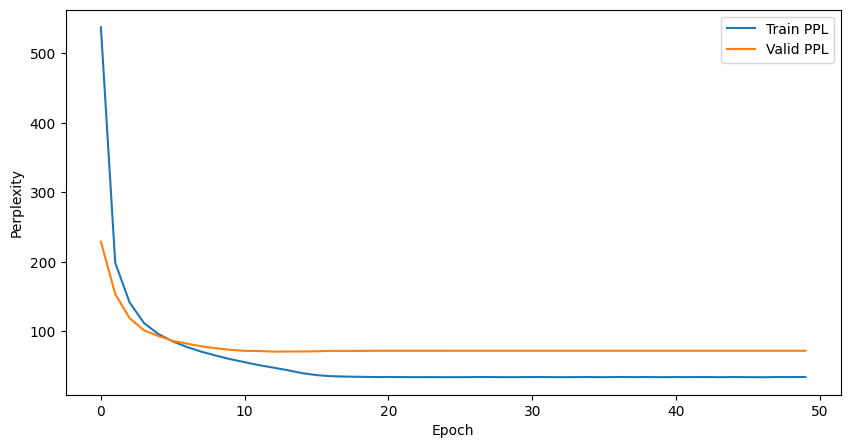

In [17]:
n_epochs = 50
clip = 0.25
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.5, patience=0)

train_losses = []
valid_losses = []
best_valid_loss = float('inf')

for epoch in range(n_epochs):
    model.train()
    epoch_train_loss = 0
    # Stateless training (re-init hidden per batch)
    for src, target in tqdm(train_loader, desc=f'Epoch {epoch+1} Train', leave=False):
        src, target = src.to(device), target.to(device)
        optimizer.zero_grad()
        hidden = model.init_hidden(src.shape[0], device)
        prediction, hidden = model(src, hidden)
        loss = criterion(prediction.reshape(-1, vocab_size), target.reshape(-1))
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()
        epoch_train_loss += loss.item()

    model.eval()
    epoch_valid_loss = 0
    with torch.no_grad():
        for src, target in valid_loader:
             src, target = src.to(device), target.to(device)
             hidden = model.init_hidden(src.shape[0], device)
             prediction, hidden = model(src, hidden)
             loss = criterion(prediction.reshape(-1, vocab_size), target.reshape(-1))
             epoch_valid_loss += loss.item()

    avg_train_loss = epoch_train_loss / len(train_loader)
    avg_valid_loss = epoch_valid_loss / len(valid_loader)
    scheduler.step(avg_valid_loss)

    train_ppl = math.exp(avg_train_loss)
    valid_ppl = math.exp(avg_valid_loss)
    train_losses.append(train_ppl)
    valid_losses.append(valid_ppl)

    print(f'Epoch: {epoch+1} | Train PPL: {train_ppl:.3f} | Valid PPL: {valid_ppl:.3f}')

    if avg_valid_loss < best_valid_loss:
        best_valid_loss = avg_valid_loss
        save_artifact(model.state_dict(), 'model.pt')

# Plot
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train PPL')
plt.plot(valid_losses, label='Valid PPL')
plt.xlabel('Epoch')
plt.ylabel('Perplexity')
plt.legend()
plt.show()

## Task 3. Text Generation
Generating text using the trained model.


In [18]:
def generate(prompt, max_seq_len, temperature, model, tokenizer, vocab, device):
    model.eval()
    tokens = tokenizer(prompt)
    indices = [vocab.stoi.get(t, vocab.unk_index) for t in tokens]
    batch_size = 1
    hidden = model.init_hidden(batch_size, device)

    with torch.no_grad():
        for i in range(max_seq_len):
            src = torch.LongTensor([indices]).to(device)
            prediction, hidden = model(src, hidden)
            probs = torch.softmax(prediction[:, -1] / temperature, dim=-1)
            prediction = torch.multinomial(probs, num_samples=1).item()
            indices.append(prediction)

    # FILTER SPECIAL TOKENS
    return [vocab.itos[i] for i in indices if vocab.itos[i] not in ['<unk>', '<eos>', '<pad>']]

# Load Best Model (with smart check)
def load_best_model():
    app_dir = os.path.join(PROJECT_PATH, 'app')
    if not os.path.exists(app_dir):
        if os.path.exists('app'): app_dir = 'app'

    path = os.path.join(app_dir, 'model.pt')
    if os.path.exists(path):
        return path
    return 'model.pt'

load_path = load_best_model()
print(f"Loading model from: {load_path}")

model.load_state_dict(torch.load(load_path, map_location=device))

prompt = "Sherlock Holmes"
print(f"Prompt: {prompt}")
print("Generated:", ' '.join(generate(prompt, 30, 0.7, model, basic_english_tokenizer, vocab, device)))

Loading model from: /content/drive/MyDrive/NLP/project_A2/app/model.pt
Prompt: Sherlock Holmes
Generated: sherlock holmes , looking out into a sheet of the lane in the door , and a for the that he had been to
